In [1]:
# did you remember to change the 'device' in general_framework.py ?
from tutorialQA_framework import *
from tutorial1_framework import *
# add more here, or comment out

device = torch.device('cuda:1') # let's use the alligator GPU
device

pygame 2.6.1 (SDL 2.28.4, Python 3.12.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
🔥 text_pretraining_data/eng_sentences_pruned-train.txt
🔥 text_pretraining_data/eng_sentences_pruned-eval.txt


device(type='cuda', index=1)

In [2]:
from visual_transformer import *
from visual_transformer.enhanced_model import *

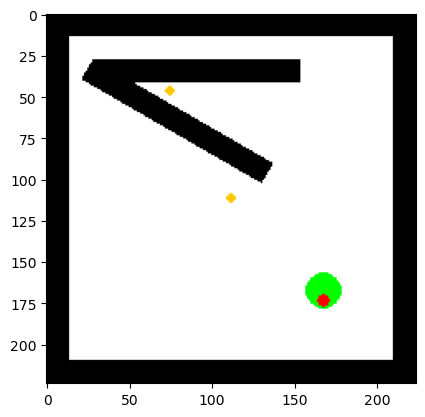

In [3]:
import matplotlib.pyplot as plt
plt.imshow(G.getData())

In [4]:
def quick_display(torch_img):
    clean = torch_img.detach().cpu()
    right_order = torch.permute(clean, (1, 2, 0))
    array = right_order.numpy()
    plt.imshow(array)

In [5]:
brain = EnhancedAgentBrain()
brain.move_to(device) # special function that wraps 'to'. Dumb? yes. Needed? Also yes.

brain.load_state_dict(torch.load('brain_checkpoints/enhanced_brain_first_training_batch10000.pth', weights_only=True, map_location=device))

<All keys matched successfully>

In [6]:
gen_optimizer = optim.Adam(brain.parameters(), lr=0.00001, eps=1e-9)

In [7]:
# should possibly also include mem_enc? Should just be gen_optimizer? 
text_optimizer = optim.Adam(list(brain.text_enc.parameters()) + list(brain.text_dec.parameters()), lr=0.00001, eps=1e-9)

In [8]:
# useful to randomize the order in which the tasks are trained
class ReusableBuffer:
    def __init__(self, L):
        self.L = L
        self.inds = list(range(len(L)))

    def draw(self, ind):
        return self.L[ind]

    def random_draw(self):
        ind_ind = random.randint(0, len(self.inds)-1)
        ind = self.inds[ind_ind]
        if ind_ind == (len(self.inds) - 1):
            self.inds = self.inds[:-1]
        else:
            self.inds = self.inds[:ind_ind] + self.inds[ind_ind + 1:]
        if len(self.inds) == 0:
            self.inds = list(range(len(self.L)))
        return self.L[ind], ind

In [9]:
# for first task (and really anywhere I want to not reset between tasks)
# make sure the batch size matches
rb = ReusableBuffer([(arrow_task_batch, gen_optimizer, 16), \
                     (qa_task_batch, text_optimizer, 16)]) # add further functions here

In [10]:
batches = [0, 0]

In [11]:
curr_mins = [1000.0, 1000.0]

In [12]:
total_losses = [0, 0]

In [13]:
#torch.autograd.set_detect_anomaly(True)

In [ ]:
total_batches = 10000*100#6250*32

for b in range(total_batches):
    triplet, ind = rb.random_draw()
    func, opt, batch_size = triplet
    
    batch_num = batches[ind]
    batches[ind] += 1

    #reset_model = True #default option; only transfer memory within the task files
    reset_model = (b % 3 == 2)

    printing = ((batch_num % 100) == 99)
    full_results = func(batch_size, brain, optimizer=opt, batch_num=batch_num, compute_grad=True, random_order=True, model_eval=False, reset_model=reset_model, printing=printing, training=True)
    L = full_results[0] # no need to look into the detailed loss report
    total_losses[ind] += L

    if printing: # if this is a significant batch
        avg_loss = total_losses[ind] / 100
        total_losses[ind] = 0
        print(f"Average total loss for task {ind}, last 100 batches: {avg_loss}\n")
        
        if avg_loss < curr_mins[ind]:
            curr_mins[ind] = avg_loss
            torch.save(brain.state_dict(), f"brain_checkpoints/enhanced_brain_first_training_v2_batch{b + 1}.pth")
            
    if b < 10:
        print(f"batch {b}, task {ind}, task batch_num {batch_num}\n")

/home/atbolsh/anaconda3/envs/player/lib/python3.12/site-packages/torch/_tensor.py:955: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


batch 0, task 1, task batch_num 0

batch 1, task 0, task batch_num 0

batch 2, task 0, task batch_num 1

batch 3, task 1, task batch_num 1

batch 4, task 1, task batch_num 2

batch 5, task 0, task batch_num 2

batch 6, task 1, task batch_num 3

batch 7, task 0, task batch_num 3

batch 8, task 1, task batch_num 4

batch 9, task 0, task batch_num 4

Total loss: 22.553747177124023:
5.90061616897583 control,
4.118896007537842 lrg,
4.552083492279053 udg,
3.9597909450531006 lra,
4.022360324859619 uda


Average total loss for task 1, last 100 batches: 30.17000051498413

Total loss: 0.49829792976379395; that's 0.24864144623279572 task and 0.24760109186172485 recon and 10.277008056640625 total text


Average total loss for task 0, last 100 batches: 0.8703511562943459

Total loss: 12.683548927307129:
5.499452590942383 control,
1.8017323017120361 lrg,
2.1801743507385254 udg,
1.4238511323928833 lra,
1.7783384323120117 uda


Average total loss for task 1, last 100 batches: 17.281756172180177

Total

In [ ]:
# Conclusion: not even close on the results. Need several days (basically seems to be relearning task1; taskQA basically
# completed)

In [ ]:
# Rerunning on top of the last results, with many more batches (so several days)